In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import os
import squidpy as sq
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
import catboost
import json
import seaborn as sns
import liana as li
import pandas as pd

from tqdm import tqdm
import sys
sys.path.append('/Users/rssantanu/Desktop/codebase/constrained_FM')


import argparse



# mouse

In [6]:
scRNA_mouse = ad.read_h5ad(os.path.join('/Users/rssantanu/Desktop/codebase/constrained_FM', 'datasets/h5ad_processed_datasets', 'GSE312025_MSmouse.h5ad'))

In [7]:
scRNA_mouse

AnnData object with n_obs × n_vars = 592421 × 239
    obs: 'x', 'y', 'area', 'sample_id', 'batch', 'region', 'type', 'time', 'CellID', 'n_genes_by_counts', 'total_counts', 'rotate', 'flip', 'project', 'NON_DA', 'DA', 'Annotation 1 (broad)', 'Annotation 2 (medium)', 'Annotation 3 (medium with DA)', 'Annotation 4 (high)', 'Annotation 3 (medium with DA)_colors', 'compartment_colors', 'Annotation 3.5', 'Annotation 3.5_colors', 'condition', 'EAE_EXP', 'slide_id', 'sample_ID', 'SCORE', 'SEX', 'compartment', 'infiltrating_cell', 'distance_to_boundary', 'distance_to_boundary_um', 'time_region', 'region_area', 'sample_area', 'type_time_comb', 'type_time_region', 'time_type', 'region_time', 'CELLID', 'x_exterior', 'y_exterior', 'library_id', 'marker_scale'
    uns: 'Annotation 1 (broad)_colors', 'Annotation 2 (medium)_colors', 'Annotation 3 (medium with DA)_colors', 'Annotation 3 (medium with DA)_wilcoxon', 'Annotation 3.5_colors', 'Annotation 4 (high)_colors', 'Annotation 4 (high)_wilcoxon', 'S

## scratch

In [18]:
scRNA_mouse.var_names

Index(['2610035D17RIK', '9630013A20RIK', 'ADORA2B', 'AIF1', 'ALDH1L1', 'ANLN',
       'ANXA5', 'ANXA8', 'APOD', 'AQP4',
       ...
       'TTR', 'TTYH1', 'TUBB3', 'VCAN', 'VTN', 'VXN', 'WFDC18', 'ZBP1',
       'ZBTB46', 'ZFAND4'],
      dtype='object', name='Gene', length=239)

In [ ]:
# import liana as li

# res = li.resource.select_resource('MouseConsensus').reset_index()

# # normalize to the expected headers
# for a,b in [
#     ('source_genesymbol','target_genesymbol'),
#     ('ligand_genesymbol','receptor_genesymbol'),
#     ('source','target'),
# ]:
#     if {a,b}.issubset(res.columns):
#         res = res.rename(columns={a:'ligand', b:'receptor'})
#         break

# # uppercase to match var_names
# res['ligand'] = res['ligand'].str.upper()
# res['receptor'] = res['receptor'].str.upper()
# scRNA_mouse.var_names = scRNA_mouse.var_names.str.upper()
li.ut.spatial_neighbors(scRNA_mouse, bandwidth=200, cutoff=0.1, kernel='gaussian', set_diag=True)
# pass the custom resource (don’t pass resource_name together)

In [ ]:
lrdata = li.mt.bivariate(
    scRNA_mouse,
    resource='MouseConsensus',
    resource_name=None,
    local_name='cosine',
    global_name='morans',
    n_perms=100,
    nz_prop=0.2,
    use_raw=False,
    verbose=True
)

Using `.raw`!
Converting to sparse csr matrix!
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
Make sure that normalized counts are passed!


Using provided `resource`.


ValueError: If 'interactions' is None, 'resource' must be a valid DataFrame with columns 'ligand' and 'receptor'.

In [ ]:
import liana as li

res = li.resource.select_resource('MouseConsensus').reset_index()

# normalize to the expected headers
for a,b in [
    ('source_genesymbol','target_genesymbol'),
    ('ligand_genesymbol','receptor_genesymbol'),
    ('source','target'),
]:
    if {a,b}.issubset(res.columns):
        res = res.rename(columns={a:'ligand', b:'receptor'})
        break

# uppercase to match var_names
res['ligand'] = res['ligand'].str.upper()
res['receptor'] = res['receptor'].str.upper()
scRNA_mouse.var_names = scRNA_mouse.var_names.str.upper()

# pass the custom resource (don’t pass resource_name together)
lrdata = li.mt.bivariate(
    scRNA_mouse,
    resource=res,
    resource_name=None,
    local_name='cosine',
    global_name='morans',
    n_perms=100,
    nz_prop=0.2,
    use_raw=False,
    verbose=True
)

Using `.X`!
Converting to sparse csr matrix!
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
Make sure that normalized counts are passed!


Using provided `resource`.


MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [ ]:
import liana as li
import pandas as pd

# 1) Inspect resource and expected column names
res = li.resource.select_resource('MouseConsensus')
res = res.reset_index()  # flatten any index
sb = li.mt.SpatialBivariate()
xcol, ycol = sb.x_name, sb.y_name  # usually 'ligand', 'receptor'
print('MouseConsensus cols:', list(res.columns))
print('expects:', xcol, ycol)

# 2) Robust renaming to what SpatialBivariate expects
candidates = [
    ('source_genesymbol', 'target_genesymbol'),
    ('ligand_genesymbol', 'receptor_genesymbol'),
    ('ligand', 'receptor'),
    ('source', 'target')
]
renamed = False
for a,b in candidates:
    if {a,b}.issubset(res.columns):
        res = res.rename(columns={a: xcol, b: ycol})
        renamed = True
        break
assert renamed and {xcol, ycol}.issubset(res.columns), "Map resource columns to ligand/receptor."

# 3) Ensure gene symbols in your data match resource case/namespace
scRNA_mouse.var_names = scRNA_mouse.var_names.str.upper()
res[xcol] = res[xcol].str.upper()
res[ycol] = res[ycol].str.upper()

# 4) Run with custom resource (do NOT pass resource_name simultaneously)
lrdata = li.mt.bivariate(
    scRNA_mouse,
    resource=res,
    resource_name=None,
    local_name='cosine',
    global_name='morans',
    n_perms=100,
    nz_prop=0.2,
    use_raw=False,
    verbose=True
)

AttributeError: module 'liana.method' has no attribute 'SpatialBivariate'

In [ ]:
import liana as li
import pandas as pd

# 1) Inspect resource and expected column names
res = li.resource.select_resource('MouseConsensus')
res = res.reset_index()  # flatten any index
sb = li.mt.SpatialBivariate()
xcol, ycol = sb.x_name, sb.y_name  # usually 'ligand', 'receptor'
print('MouseConsensus cols:', list(res.columns))
print('expects:', xcol, ycol)

# 2) Robust renaming to what SpatialBivariate expects
candidates = [
    ('source_genesymbol', 'target_genesymbol'),
    ('ligand_genesymbol', 'receptor_genesymbol'),
    ('ligand', 'receptor'),
    ('source', 'target')
]
renamed = False
for a,b in candidates:
    if {a,b}.issubset(res.columns):
        res = res.rename(columns={a: xcol, b: ycol})
        renamed = True
        break
assert renamed and {xcol, ycol}.issubset(res.columns), "Map resource columns to ligand/receptor."

# 3) Ensure gene symbols in your data match resource case/namespace
scRNA_mouse.var_names = scRNA_mouse.var_names.str.upper()
res[xcol] = res[xcol].str.upper()
res[ycol] = res[ycol].str.upper()

# 4) Run with custom resource (do NOT pass resource_name simultaneously)
lrdata = li.mt.bivariate(
    scRNA_mouse,
    resource=res,
    resource_name=None,
    local_name='cosine',
    global_name='morans',
    n_perms=100,
    nz_prop=0.2,
    use_raw=False,
    verbose=True
)

AttributeError: module 'liana.method' has no attribute 'SpatialBivariate'

In [ ]:
import liana as li
import pandas as pd

# 1) Inspect resource and expected column names
res = li.resource.select_resource('MouseConsensus')
res = res.reset_index()  # flatten any index
sb = li.mt.SpatialBivariate()
xcol, ycol = sb.x_name, sb.y_name  # usually 'ligand', 'receptor'
print('MouseConsensus cols:', list(res.columns))
print('expects:', xcol, ycol)

# 2) Robust renaming to what SpatialBivariate expects
candidates = [
    ('source_genesymbol', 'target_genesymbol'),
    ('ligand_genesymbol', 'receptor_genesymbol'),
    ('ligand', 'receptor'),
    ('source', 'target')
]
renamed = False
for a,b in candidates:
    if {a,b}.issubset(res.columns):
        res = res.rename(columns={a: xcol, b: ycol})
        renamed = True
        break
assert renamed and {xcol, ycol}.issubset(res.columns), "Map resource columns to ligand/receptor."

# 3) Ensure gene symbols in your data match resource case/namespace
scRNA_mouse.var_names = scRNA_mouse.var_names.str.upper()
res[xcol] = res[xcol].str.upper()
res[ycol] = res[ycol].str.upper()

# 4) Run with custom resource (do NOT pass resource_name simultaneously)
lrdata = li.mt.bivariate(
    scRNA_mouse,
    resource=res,
    resource_name=None,
    local_name='cosine',
    global_name='morans',
    n_perms=100,
    nz_prop=0.2,
    use_raw=False,
    verbose=True
)

AttributeError: module 'liana.method' has no attribute 'SpatialBivariate'

In [ ]:
import liana as li
import pandas as pd

# 1) Inspect resource and expected column names
res = li.resource.select_resource('MouseConsensus')
res = res.reset_index()  # flatten any index
sb = li.mt.SpatialBivariate()
xcol, ycol = sb.x_name, sb.y_name  # usually 'ligand', 'receptor'
print('MouseConsensus cols:', list(res.columns))
print('expects:', xcol, ycol)

# 2) Robust renaming to what SpatialBivariate expects
candidates = [
    ('source_genesymbol', 'target_genesymbol'),
    ('ligand_genesymbol', 'receptor_genesymbol'),
    ('ligand', 'receptor'),
    ('source', 'target')
]
renamed = False
for a,b in candidates:
    if {a,b}.issubset(res.columns):
        res = res.rename(columns={a: xcol, b: ycol})
        renamed = True
        break
assert renamed and {xcol, ycol}.issubset(res.columns), "Map resource columns to ligand/receptor."

# 3) Ensure gene symbols in your data match resource case/namespace
scRNA_mouse.var_names = scRNA_mouse.var_names.str.upper()
res[xcol] = res[xcol].str.upper()
res[ycol] = res[ycol].str.upper()

# 4) Run with custom resource (do NOT pass resource_name simultaneously)
lrdata = li.mt.bivariate(
    scRNA_mouse,
    resource=res,
    resource_name=None,
    local_name='cosine',
    global_name='morans',
    n_perms=100,
    nz_prop=0.2,
    use_raw=False,
    verbose=True
)

AttributeError: module 'liana.method' has no attribute 'SpatialBivariate'

In [ ]:
import liana as li
import pandas as pd

# 1) Inspect resource and expected column names
res = li.resource.select_resource('MouseConsensus')
res = res.reset_index()  # flatten any index
sb = li.mt.SpatialBivariate()
xcol, ycol = sb.x_name, sb.y_name  # usually 'ligand', 'receptor'
print('MouseConsensus cols:', list(res.columns))
print('expects:', xcol, ycol)

# 2) Robust renaming to what SpatialBivariate expects
candidates = [
    ('source_genesymbol', 'target_genesymbol'),
    ('ligand_genesymbol', 'receptor_genesymbol'),
    ('ligand', 'receptor'),
    ('source', 'target')
]
renamed = False
for a,b in candidates:
    if {a,b}.issubset(res.columns):
        res = res.rename(columns={a: xcol, b: ycol})
        renamed = True
        break
assert renamed and {xcol, ycol}.issubset(res.columns), "Map resource columns to ligand/receptor."

# 3) Ensure gene symbols in your data match resource case/namespace
scRNA_mouse.var_names = scRNA_mouse.var_names.str.upper()
res[xcol] = res[xcol].str.upper()
res[ycol] = res[ycol].str.upper()

# 4) Run with custom resource (do NOT pass resource_name simultaneously)
lrdata = li.mt.bivariate(
    scRNA_mouse,
    resource=res,
    resource_name=None,
    local_name='cosine',
    global_name='morans',
    n_perms=100,
    nz_prop=0.2,
    use_raw=False,
    verbose=True
)

AttributeError: module 'liana.method' has no attribute 'SpatialBivariate'

In [ ]:
import liana as li
import pandas as pd

# 1) Inspect resource and expected column names
res = li.resource.select_resource('MouseConsensus')
res = res.reset_index()  # flatten any index
sb = li.mt.SpatialBivariate()
xcol, ycol = sb.x_name, sb.y_name  # usually 'ligand', 'receptor'
print('MouseConsensus cols:', list(res.columns))
print('expects:', xcol, ycol)

# 2) Robust renaming to what SpatialBivariate expects
candidates = [
    ('source_genesymbol', 'target_genesymbol'),
    ('ligand_genesymbol', 'receptor_genesymbol'),
    ('ligand', 'receptor'),
    ('source', 'target')
]
renamed = False
for a,b in candidates:
    if {a,b}.issubset(res.columns):
        res = res.rename(columns={a: xcol, b: ycol})
        renamed = True
        break
assert renamed and {xcol, ycol}.issubset(res.columns), "Map resource columns to ligand/receptor."

# 3) Ensure gene symbols in your data match resource case/namespace
scRNA_mouse.var_names = scRNA_mouse.var_names.str.upper()
res[xcol] = res[xcol].str.upper()
res[ycol] = res[ycol].str.upper()

# 4) Run with custom resource (do NOT pass resource_name simultaneously)
lrdata = li.mt.bivariate(
    scRNA_mouse,
    resource=res,
    resource_name=None,
    local_name='cosine',
    global_name='morans',
    n_perms=100,
    nz_prop=0.2,
    use_raw=False,
    verbose=True
)

AttributeError: module 'liana.method' has no attribute 'SpatialBivariate'

In [ ]:
import liana as li
import pandas as pd

# 1) Inspect resource and expected column names
res = li.resource.select_resource('MouseConsensus')
res = res.reset_index()  # flatten any index
sb = li.mt.SpatialBivariate()
xcol, ycol = sb.x_name, sb.y_name  # usually 'ligand', 'receptor'
print('MouseConsensus cols:', list(res.columns))
print('expects:', xcol, ycol)

# 2) Robust renaming to what SpatialBivariate expects
candidates = [
    ('source_genesymbol', 'target_genesymbol'),
    ('ligand_genesymbol', 'receptor_genesymbol'),
    ('ligand', 'receptor'),
    ('source', 'target')
]
renamed = False
for a,b in candidates:
    if {a,b}.issubset(res.columns):
        res = res.rename(columns={a: xcol, b: ycol})
        renamed = True
        break
assert renamed and {xcol, ycol}.issubset(res.columns), "Map resource columns to ligand/receptor."

# 3) Ensure gene symbols in your data match resource case/namespace
scRNA_mouse.var_names = scRNA_mouse.var_names.str.upper()
res[xcol] = res[xcol].str.upper()
res[ycol] = res[ycol].str.upper()

# 4) Run with custom resource (do NOT pass resource_name simultaneously)
lrdata = li.mt.bivariate(
    scRNA_mouse,
    resource=res,
    resource_name=None,
    local_name='cosine',
    global_name='morans',
    n_perms=100,
    nz_prop=0.2,
    use_raw=False,
    verbose=True
)

AttributeError: module 'liana.method' has no attribute 'SpatialBivariate'

In [ ]:
import liana as li
import pandas as pd

# 1) Inspect resource and expected column names
res = li.resource.select_resource('MouseConsensus')
res = res.reset_index()  # flatten any index
sb = li.mt.SpatialBivariate()
xcol, ycol = sb.x_name, sb.y_name  # usually 'ligand', 'receptor'
print('MouseConsensus cols:', list(res.columns))
print('expects:', xcol, ycol)

# 2) Robust renaming to what SpatialBivariate expects
candidates = [
    ('source_genesymbol', 'target_genesymbol'),
    ('ligand_genesymbol', 'receptor_genesymbol'),
    ('ligand', 'receptor'),
    ('source', 'target')
]
renamed = False
for a,b in candidates:
    if {a,b}.issubset(res.columns):
        res = res.rename(columns={a: xcol, b: ycol})
        renamed = True
        break
assert renamed and {xcol, ycol}.issubset(res.columns), "Map resource columns to ligand/receptor."

# 3) Ensure gene symbols in your data match resource case/namespace
scRNA_mouse.var_names = scRNA_mouse.var_names.str.upper()
res[xcol] = res[xcol].str.upper()
res[ycol] = res[ycol].str.upper()

# 4) Run with custom resource (do NOT pass resource_name simultaneously)
lrdata = li.mt.bivariate(
    scRNA_mouse,
    resource=res,
    resource_name=None,
    local_name='cosine',
    global_name='morans',
    n_perms=100,
    nz_prop=0.2,
    use_raw=False,
    verbose=True
)

AttributeError: module 'liana.method' has no attribute 'SpatialBivariate'

In [15]:
lrdata = li.mt.bivariate(scRNA_mouse,
                resource_name='MouseConsensus',
                local_name='cosine', # Name of the function
                global_name="morans", # Name global function
                n_perms=100, # Number of permutations to calculate a p-value
                mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
                add_categories=True, # Whether to add local categories to the results
                nz_prop=0.2, # Minimum expr. proportion for ligands/receptors and their subunits
                use_raw=False,
                verbose=True
                )

Using `.X`!
Converting to sparse csr matrix!
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
Make sure that normalized counts are passed!
Using resource `MouseConsensus`.


MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [57]:
# four categories of time we have
time= scRNA_mouse.obs['time']

# these are the sample ids we have; what's the difference?
sample_id= scRNA_mouse.obs['sample_id']
sample_ID= scRNA_mouse.obs['sample_ID']

# ['CNTRL', 'EAE']; what is this exactly?
dtype= scRNA_mouse.obs['type']

#
CELLID= scRNA_mouse.obs['CELLID']
CellID= scRNA_mouse.obs['CellID']

# what are these?
batch= scRNA_mouse.obs['batch']
region= scRNA_mouse.obs['region']

# these are the annotations for the cells with different granularity levels
annotation_1_broad= scRNA_mouse.obs['Annotation 1 (broad)'] # least granular level
annotation_2_medium= scRNA_mouse.obs['Annotation 2 (medium)'] # medium granularity level
annotation_3_medium= scRNA_mouse.obs['Annotation 3 (medium with DA)'] # medium granularity level with DA
annotation_4_high= scRNA_mouse.obs['Annotation 4 (high)'] # most granular level

In [58]:
time

R01_C_CNTRL_PEAK_4      PEAK
R01_C_CNTRL_PEAK_7      PEAK
R01_C_CNTRL_PEAK_8      PEAK
R01_C_CNTRL_PEAK_17     PEAK
R01_C_CNTRL_PEAK_29     PEAK
                        ... 
R10_C_EAE_LATE_11298    LATE
R10_C_EAE_LATE_11299    LATE
R10_C_EAE_LATE_11300    LATE
R10_C_EAE_LATE_11301    LATE
R10_C_EAE_LATE_11302    LATE
Name: time, Length: 592421, dtype: category
Categories (4, object): ['EARLY_NS', 'EARLY_SO', 'LATE', 'PEAK']

In [59]:
sample_id

R01_C_CNTRL_PEAK_4      R01_C_CNTRL_PEAK
R01_C_CNTRL_PEAK_7      R01_C_CNTRL_PEAK
R01_C_CNTRL_PEAK_8      R01_C_CNTRL_PEAK
R01_C_CNTRL_PEAK_17     R01_C_CNTRL_PEAK
R01_C_CNTRL_PEAK_29     R01_C_CNTRL_PEAK
                              ...       
R10_C_EAE_LATE_11298      R10_C_EAE_LATE
R10_C_EAE_LATE_11299      R10_C_EAE_LATE
R10_C_EAE_LATE_11300      R10_C_EAE_LATE
R10_C_EAE_LATE_11301      R10_C_EAE_LATE
R10_C_EAE_LATE_11302      R10_C_EAE_LATE
Name: sample_id, Length: 592421, dtype: category
Categories (52, object): ['R00_L_EAE_EARLY', 'R01_B_CNTRL_PEAK', 'R01_B_EAE_PEAK', 'R01_C_CNTRL_PEAK', ..., 'R09_C_CNTRL_LATE', 'R09_C_EAE_LATE', 'R10_C_CNTRL_LATE', 'R10_C_EAE_LATE']

In [60]:
CELLID

R01_C_CNTRL_PEAK_4          4
R01_C_CNTRL_PEAK_7          7
R01_C_CNTRL_PEAK_8          8
R01_C_CNTRL_PEAK_17        17
R01_C_CNTRL_PEAK_29        29
                        ...  
R10_C_EAE_LATE_11298    11298
R10_C_EAE_LATE_11299    11299
R10_C_EAE_LATE_11300    11300
R10_C_EAE_LATE_11301    11301
R10_C_EAE_LATE_11302    11302
Name: CELLID, Length: 592421, dtype: category
Categories (114100, object): ['1', '2', '3', '4', ..., '117407', '117408', '117409', '117411']

In [61]:
batch

R01_C_CNTRL_PEAK_4      spinal cord
R01_C_CNTRL_PEAK_7      spinal cord
R01_C_CNTRL_PEAK_8      spinal cord
R01_C_CNTRL_PEAK_17     spinal cord
R01_C_CNTRL_PEAK_29     spinal cord
                           ...     
R10_C_EAE_LATE_11298            R10
R10_C_EAE_LATE_11299            R10
R10_C_EAE_LATE_11300            R10
R10_C_EAE_LATE_11301            R10
R10_C_EAE_LATE_11302            R10
Name: batch, Length: 592421, dtype: category
Categories (13, object): ['R00', 'R01', 'R02', 'R03', ..., 'R09', 'R10', 'brain', 'spinal cord']

In [62]:
region

R01_C_CNTRL_PEAK_4      C
R01_C_CNTRL_PEAK_7      C
R01_C_CNTRL_PEAK_8      C
R01_C_CNTRL_PEAK_17     C
R01_C_CNTRL_PEAK_29     C
                       ..
R10_C_EAE_LATE_11298    C
R10_C_EAE_LATE_11299    C
R10_C_EAE_LATE_11300    C
R10_C_EAE_LATE_11301    C
R10_C_EAE_LATE_11302    C
Name: region, Length: 592421, dtype: category
Categories (4, object): ['B', 'C', 'L', 'T']

/var/folders/mc/s2w117k11cj56552qbkf28zw0000gn/T/ipykernel_91515/2984955465.py:26: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[annotation_key] = adata.obs[annotation_key].astype(str)
/var/folders/mc/s2w117k11cj56552qbkf28zw0000gn/T/ipykernel_91515/2984955465.py:26: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[annotation_key] = adata.obs[annotation_key].astype(str)
/var/folders/mc/s2w117k11cj56552qbkf28zw0000gn/T/ipykernel_91515/2984955465.py:26: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[annotation_key] = adata.obs[annotation_key].astype(str)
/var/folders/mc/s2w117k11cj56552qbkf28zw0000gn/T/ipykernel_91515/2984955465.py:26: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[annotation_key] = adata.obs[annotation_key].asty

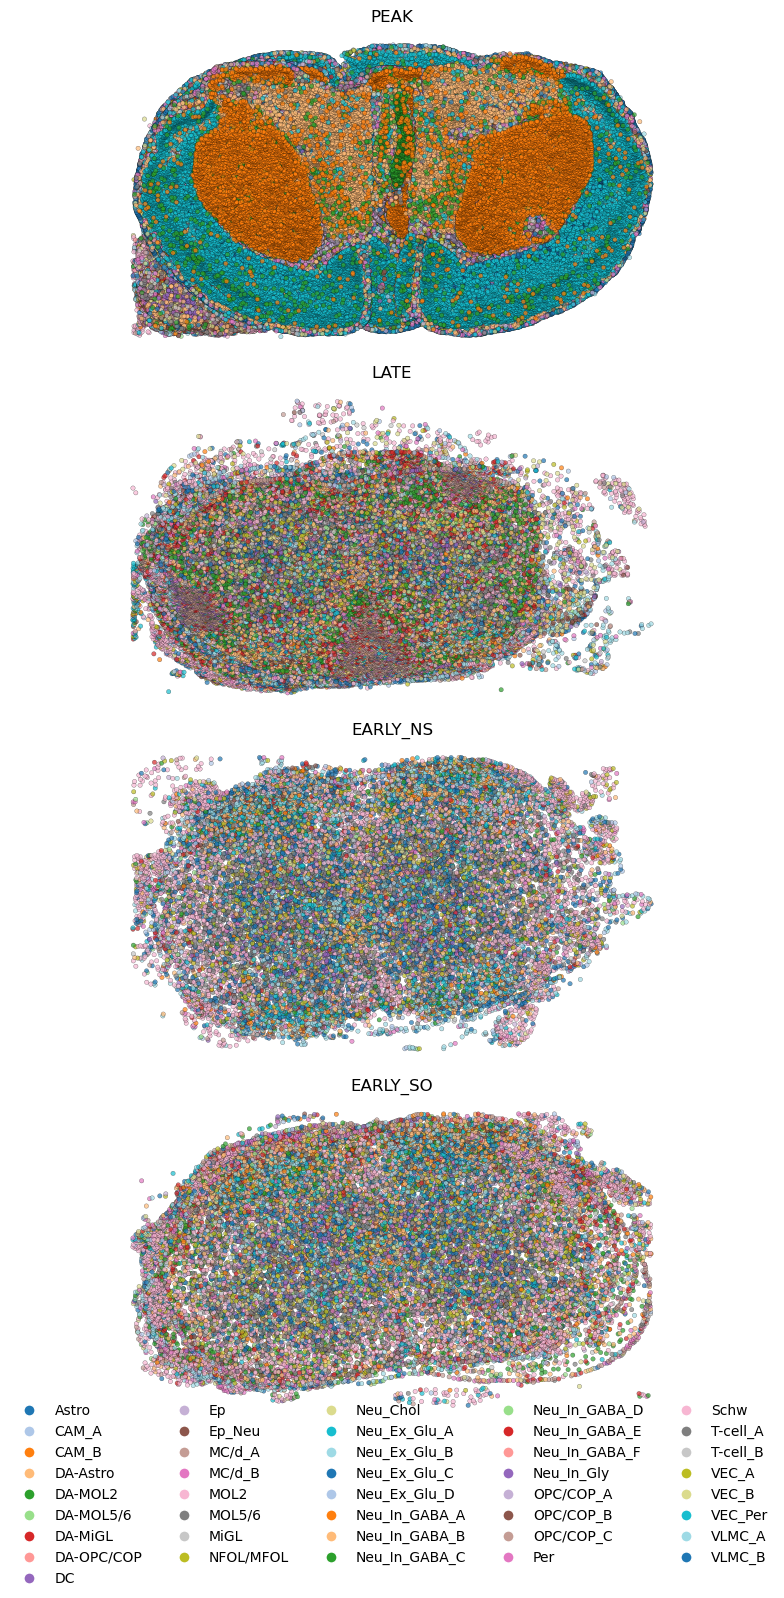

In [73]:
# Extract all unique cell types across all datasets
all_cell_types = set()
annotation_key= "Annotation 4 (high)"
# annotation_key= "Annotation 3 (medium with DA)"
# annotation_key= "Annotation 2 (medium)"
# annotation_key= "Annotation 1 (broad)"
all_cell_types.update(scRNA_mouse.obs[annotation_key].unique())

# Create a consistent color map for all cell types
palette = sns.color_palette("tab20", len(all_cell_types))
color_dict = dict(zip(sorted(all_cell_types), palette))

time= scRNA_mouse.obs['time'].unique()


# Plot each dataset one by one
fig, axes = plt.subplots(len(time), 1, figsize=(6, 4 * len(time)))

if len(time) == 1:  # Ensure axes is iterable when only one dataset
    axes = [axes]


for ax, stage in zip(axes, time):
    # Assign colors based on the global dictionary
    adata= scRNA_mouse[scRNA_mouse.obs['time'] == stage]
    adata.obs[annotation_key] = adata.obs[annotation_key].astype(str)
    adata.obs["color"] = adata.obs[annotation_key].map(color_dict)

    # Plot spatial coordinates
    ax.scatter(
        adata.obsm["spatial"][:, 0], 
        adata.obsm["spatial"][:, 1], 
        c=adata.obs["color"], 
        s=10, alpha=0.7, edgecolors="k", linewidth=0.2
    )
    
    ax.set_title(stage, fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

# Create a single legend at the bottom
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[cell], markersize=8) 
           for cell in sorted(all_cell_types)]
labels = sorted(all_cell_types)

fig.legend(handles, labels, loc='lower center', ncol=5, fontsize=10, frameon=False)

plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to fit the legend
plt.show()

# human
#### does not have temporal resolution; different static data from different patients

In [10]:
scRNA_human = ad.read_h5ad(os.path.join('/Users/rssantanu/Desktop/codebase/constrained_FM', 'datasets/h5ad_processed_datasets', 'GSE312025_MShuman.h5ad'))


In [11]:
scRNA_human

AnnData object with n_obs × n_vars = 660801 × 266
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'sample_id', 'n_counts', 'batch', 'type', 'type_spec', 'leiden_0.1', 'leiden_0.5', 'leiden_1', 'leiden_1.5', 'leiden_2', 'project', 'rotate', 'flip', 'Level0', 'reclustered_Level0', 'x_rotated_2', 'y_rotated_2', 'sex', 'age', 'y_rotated_mod', 'x_rotated_mod', 'Level1', 'Level2', 'Level3', 'compartment', 'compartment_2', 'compartment_2_colors', 'region_area', 'Level1_5', 'library_id'
    uns: 'Level0_colors', 'Level0_wilcoxon', 'Level1_5_colors', 'Level1_5_wilcoxon', 'Level1_colors', 'Level1_wilcoxon', 'Level2_colors', 'Level2_wilcoxon', 'Level3_colors', 'Level3_wilcoxon', 'age_colors', 'compartment_2_colors', 'compartment_colors', 'dendrogram_Level1_5', 'leiden', 'leiden_0.1_colors', 'leiden_0.5_colors', 'leiden_1.5_colors', 'leiden_1_colors', '

In [ ]:
age= scRNA_human.obs['age']

# these are the sample ids we have; what's the difference?
sample_id= scRNA_human.obs['sample_id']

# ['CNTRL', 'EAE']; what is this exactly?
dtype= scRNA_human.obs['type']

# 
cell_id= scRNA_human.obs['cell_id']

# 
Level1= scRNA_human.obs['Level1']
Level2= scRNA_human.obs['Level2']
Level3= scRNA_human.obs['Level3']

In [36]:
age.unique()

array([53, 66, 57, 72, 47, 58])

In [37]:
sample_id.unique()

['MSa1', 'MSa2', 'CTRL2', 'CTRL1', 'MSi2', 'MSi1']
Categories (6, object): ['MSa1', 'MSa2', 'CTRL2', 'CTRL1', 'MSi2', 'MSi1']

In [38]:
dtype.unique()

['MS', 'CNTRL']
Categories (2, object): ['CNTRL', 'MS']

In [33]:
from collections import Counter

Counter(scRNA_human.obs['type'])

Counter({'MS': 465294, 'CNTRL': 195507})